# Cybersecurity Threat Detection: CICIDS 2017 Dataset (Kaggle).

## Preprocess the dataset 

### Import libraries and datasets

In [1]:
# Import all libraries needed. 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

ModuleNotFoundError: No module named 'pandas'

In [7]:
# Load each dataset
monday = pd.read_csv('dataset/Monday-WorkingHours.pcap_ISCX.csv')
tuesday = pd.read_csv('dataset/Tuesday-WorkingHours.pcap_ISCX.csv')
wednesday = pd.read_csv('dataset/Wednesday-workingHours.pcap_ISCX.csv')
thursday = pd.read_csv('dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
friday_ddos = pd.read_csv('dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
friday_portscan = pd.read_csv('dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')

# Add a 'Day' column
monday['Day'] = 'Monday'
tuesday['Day'] = 'Tuesday'
wednesday['Day'] = 'Wednesday'
thursday['Day'] = 'Thursday'
friday_ddos['Day'] = 'Friday-DDOS'
friday_portscan['Day'] = 'Friday-PortScan'

# Combine all datasets
all_data = pd.concat([monday, tuesday, wednesday, thursday, friday_ddos, friday_portscan], ignore_index=True)

# Display combined dataset info
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351108 entries, 0 to 2351107
Data columns (total 80 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

### Clean the dataset 

In [13]:
print(all_data.isnull().sum())

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Day                            0
Length: 80, dtype: int64


### Exploring the data

In [17]:
# Summary of the dataset
print(all_data.describe())

        Destination Port   Flow Duration   Total Fwd Packets  \
count       2.351108e+06    2.351108e+06        2.351108e+06   
mean        8.163563e+03    1.575419e+07        9.382722e+00   
std         1.849374e+04    3.446849e+07        7.603036e+02   
min         0.000000e+00   -1.300000e+01        1.000000e+00   
25%         5.300000e+01    1.630000e+02        1.000000e+00   
50%         8.000000e+01    3.574800e+04        2.000000e+00   
75%         4.430000e+02    4.915053e+06        5.000000e+00   
max         6.553500e+04    1.200000e+08        2.197590e+05   

        Total Backward Packets  Total Length of Fwd Packets  \
count             2.351108e+06                 2.351108e+06   
mean              1.041678e+01                 5.431112e+02   
std               1.009094e+03                 5.641114e+03   
min               0.000000e+00                 0.000000e+00   
25%               1.000000e+00                 1.200000e+01   
50%               2.000000e+00               

Label
BENIGN                        1795464
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


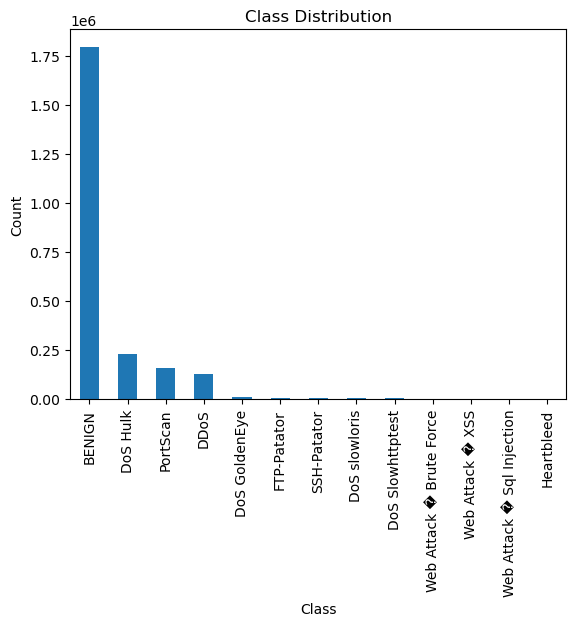

In [27]:
# Strip leading and trailing whitespace from column names
all_data.columns = all_data.columns.str.strip()

# Now access the 'Label' column
print(all_data['Label'].value_counts())

all_data['Label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

                              min           max
Destination Port             22.0  6.194865e+04
Flow Duration                 1.0  1.177242e+08
Total Fwd Packets             1.0  4.700000e+01
Total Backward Packets        0.0  5.500000e+01
Total Length of Fwd Packets   0.0  1.160100e+04
...                           ...           ...
Active Min                    0.0  1.783040e+06
Idle Mean                     0.0  9.990000e+07
Idle Std                      0.0  2.660000e+07
Idle Max                      0.0  9.990000e+07
Idle Min                      0.0  9.990000e+07

[78 rows x 2 columns]


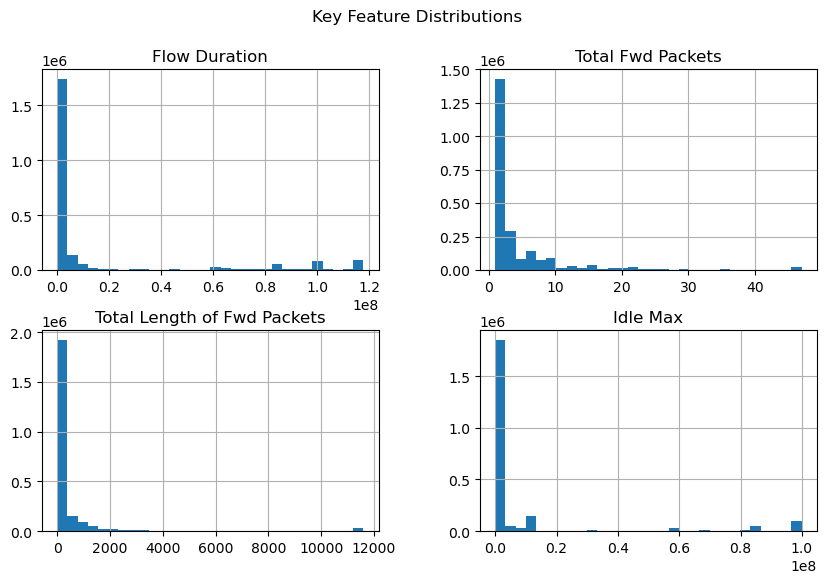

In [51]:
# Select numerical columns
numerical_columns = all_data.select_dtypes(include=['number']).columns

# Cap extreme values at the 1st and 99th percentiles
for col in numerical_columns:
    lower_bound = all_data[col].quantile(0.01)  # 1st percentile
    upper_bound = all_data[col].quantile(0.99)  # 99th percentile
    all_data[col] = all_data[col].clip(lower=lower_bound, upper=upper_bound)

# Verify the new range
print(all_data[numerical_columns].agg(['min', 'max']).T)

# List of key features
key_features = ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Idle Max']

# Plot histograms for key features
all_data[key_features].hist(figsize=(10, 6), bins=30)
plt.suptitle('Key Feature Distributions')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



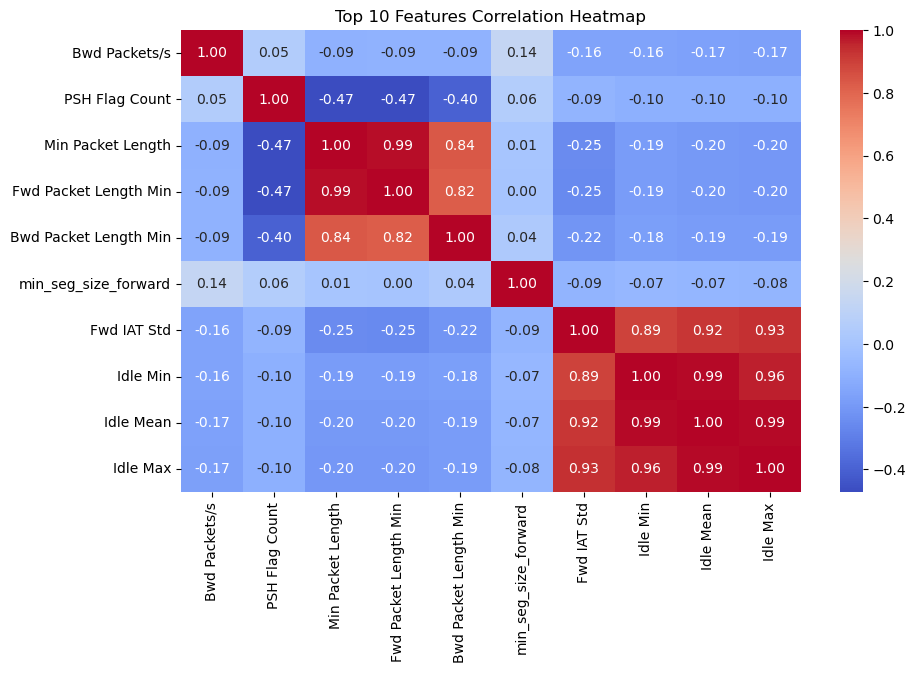

In [73]:

# Encode the 'Label' column
le = LabelEncoder()
all_data['Label_Encoded'] = le.fit_transform(all_data['Label'])

# Recalculate correlations with the target variable (Label_Encoded)
target_corr = numerical_data.corrwith(all_data['Label_Encoded']).abs().sort_values(ascending=False)

# Select top 10 most correlated features
top_features = target_corr.head(10).index

# Plot heatmap for top features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data[top_features].corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Top 10 Features Correlation Heatmap')
plt.show()